# Homework 4 - Recommendation systems and clustering everywhere

Memebers of the Group 5:
- Arman Feili: <armanfeili7@gmail.com>, [GitHub](https://github.com/armanfeili)
- Livia Oddi: <oddi.184685@studenti.uniroma1.it>, [GitHub](https://github.com/Livia020799)
- Ahmad Saad: <Ahmad.saaddm@gmail.com>, [GitHub](https://github.com/Ahmadsaaddm)
- Edo Fejzic: <edo.fejzic@hotmail.com>, [GitHub](https://github.com/do3-173)

## 1. Recommendation sytem 


Implementing a recommendation system is critical for businesses and digital platforms that want to thrive in today's competitive environment. These systems use data-driven personalization to tailor content, products, and services to individual user preferences. The latter improves user engagement, satisfaction, retention, and revenue through increased sales and cross-selling opportunities. In this section, you will attempt to implement a recommendation system by identifying similar users' preferences and recommending movies they watch to the study user. 

To be more specific, you will implement your version of the [**LSH algorithm**](https://www.learndatasci.com/tutorials/building-recommendation-engine-locality-sensitive-hashing-lsh-python/), which will take as input the user's preferred genre of movies, find the most similar users to this user, and recommend the most watched movies by those who are more similar to the user. 

__Data__: The data you will be working with can be found [here](https://www.kaggle.com/datasets/vodclickstream/netflix-audience-behaviour-uk-movies).

Looking at the data, you can see that there is data available for each user for the movies the user <ins>clicked on</ins>. Gather the __title and genre__ of the __maximum top 10 movies__ that each user clicked on regarding the __number of clicks__.

### 1.2 Minhash Signatures 
Using the movie genre and user_ids, try to implement your min-hash signatures so that users with similar interests in a genre appear in the same bucket. 

__Important note:__ You must write your minhash function from scratch.  You are not permitted to use any already implemented hash functions.  Read the class materials and, if necessary, conduct an internet search.  The description of hash functions in the [book](http://infolab.stanford.edu/~ullman/mmds/ch3n.pdf) may be helpful as a reference.

### 1.3 Locality-Sensitive Hashing (LSH)

Now that your buckets are ready, it's time to ask a few queries. We will provide you with some user_ids and ask you to recommend at __most five movies__ to the user to watch based on the movies clicked by similar users. 

To recommend at most five movies given a user_id, use the following procedure: 

1. Identify the <ins>two most similar</ins> users to this user.
2. If these two users have any movies __in common__, recommend those movies based on the total number of clicks by these users.
3. If there are __no more common__ movies, try to propose the most clicked movies by the __most similar user first__, followed by the other user. 

__Note:__ At the end of the process, we expect to see at most five movies recommended to the user.

__Example:__ assume you've identified user __A__ and __B__ as the most similar users to a single user, and we have the following records on these users: 

- User A with 80% similarity
- User B with 50% similarity
  
|user|movie title|#clicks|
|---|---|---|
|A|Wild Child|20|
|A|Innocence|10|
|A|Coin Heist|2|
|B|Innocence|30|
|B|Coin Heist|15|
|B|Before I Fall|30|
|B|Beyond Skyline|8|
|B|The Amazing Spider-Man|5|

- __Recommended movies__ in order:
    - Innocence
    - Coin Heist
    - Wild Child
    - Before I Fall
    - Beyond Skyline

In [ ]:
# Libraries

from tqdm import tqdm
import pandas as pd
import numpy as np
import random

In [ ]:
# Reading the initial dataframe
netflix_df = pd.read_csv(r'C:\Users\ahmad\Desktop\sap\adm\HW4\archive (1)\vodclickstream_uk_movies_03.csv')


In [ ]:
# a copy of the dataframe so i dont overwrite
succ_movies = netflix_df.copy()
succ_movies.drop(['movie_id', 'release_date','datetime'], axis = 1)
succ_movies = succ_movies.sort_values(["user_id", "movie_id", "datetime", "duration"])


In [ ]:
# calculating number of clicks for every user for every movie
#RQ 1,1
user_movie_clicks = succ_movies.groupby(['user_id', 'movie_id', 'title','genres']).size().reset_index(name='clicks')


In [ ]:
#Filtering the top movies per user for genres column, to perform hashing
import re
top_movies_per_user = user_movie_clicks.sort_values('clicks', ascending=False).groupby('user_id').head(10)

top_movies_per_user.sort_values(by = ['user_id','clicks'], ascending = False)
top_movies_per_user['filtered_genres'] = top_movies_per_user['genres'].apply(lambda x: re.sub(r'[^\w\s]', '', x.lower()))

top_movies_per_user.drop_duplicates(subset='user_id', keep='first', inplace=True)



In [ ]:
def hashing(nums, a=31):
    hash_val = 0
    
    for num in nums:
        
        for char in str(num):
            #  'hash_val * a' scales the current hash
            # ord converts string into ascii value
            hash_val = (hash_val * a + ord(char)) 
    return hash_val


In [ ]:
#considering the single genre itself as a shingle, sufficient enough for our engine
top_movies_per_user['shingles'] = top_movies_per_user['filtered_genres'].str.split()


In [ ]:
#creating a list of unique genres from our dataframe
genres_list = top_movies_per_user['filtered_genres'].to_list()
genres_set = set()

for gl in genres_list:
    genres = gl.split()
    genres_set.update(genres)

genres_set = list(genres_set)
    

In [ ]:

#creating a unique list of user ids

unique_users_list = top_movies_per_user['user_id'].unique().tolist()

#Initializing our characteristic matrix with zeros
char_matrix = pd.DataFrame(0, index=unique_users_list, columns=list(genres_set))

#the column indexes will be genres and for the rows it will be the user ids
#putting 1 where we have a user with a  certain genre
for index, row in tqdm(top_movies_per_user.iterrows(), total=len(top_movies_per_user), desc="Filling Signature Matrix"):
    user_id = row['user_id']
    genres = row['filtered_genres'].split()
    
    for genre in genres:
        value_to_set = 1
        char_matrix.at[user_id, genre] = value_to_set

Filling Signature Matrix: 100%|██████████| 161918/161918 [00:19<00:00, 8490.47it/s]


After creating our characteristic matrix we have to create our signature matrix using minhashing.

In [ ]:
#Creating a minhash function to perform it on our characteristic matrix
def min_hashing(char_matrix, hashing, num_hashes):
    # initialize the signature matrix with infinity
    signature_matrix = pd.DataFrame(np.inf, index=char_matrix.index, columns=range(num_hashes))

    # For each hash function, compute the min hash across all genres for each user
    for user in tqdm(char_matrix.index, desc="Computing MinHash for each user"):
        for i in range(num_hashes):
            #computing the minimum hash value for the user and current hash function 
            #if the user has a mark for 1 in the characteristic matrix, calculate hash and track minimum
            min_hash = min([hashing(genre) * (i + 1) % 1000000 for genre in char_matrix.columns if char_matrix.at[user, genre] == 1])
            #we have to ensure a unique hash for every function 
            signature_matrix.at[user, i] = min_hash
            #update minimum hash value for this user and hash function 
    return signature_matrix


In [ ]:
num_hashes = 30  #arbitrary number of hashes
signature_matrix = min_hashing(char_matrix, hashing,num_hashes)


Computing MinHash for each user: 100%|██████████| 161918/161918 [12:20<00:00, 218.77it/s]


In [ ]:
signature_matrix
#column  indicates hash function index 

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
7cdfd0e14a,543078.0,86156.0,534901.0,172312.0,224835.0,69802.0,424537.0,342328.0,260119.0,177910.0,...,273611.0,191402.0,109193.0,26984.0,124175.0,120028.0,663106.0,206184.0,504043.0,292340.0
23c52f9b50,144281.0,86156.0,432843.0,172312.0,715390.0,83744.0,9967.0,154248.0,298529.0,430780.0,...,29901.0,174182.0,154352.0,33872.0,515600.0,120028.0,663106.0,39868.0,184149.0,292340.0
59416738c3,144281.0,288562.0,432843.0,577124.0,588955.0,506746.0,9967.0,154248.0,260119.0,177910.0,...,29901.0,174182.0,109193.0,26984.0,607025.0,751306.0,780357.0,39868.0,184149.0,328430.0
e06f0be797,16438.0,32876.0,49314.0,65752.0,82190.0,98628.0,9967.0,96640.0,147942.0,164380.0,...,29901.0,15760.0,318463.0,289920.0,228450.0,157588.0,86726.0,15864.0,184149.0,112400.0
49d091aa63,144281.0,288562.0,432843.0,577124.0,259140.0,506746.0,9967.0,154248.0,260119.0,177910.0,...,29901.0,174182.0,109193.0,26984.0,295700.0,751306.0,599356.0,39868.0,184149.0,328430.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5fdd93fc0c,180624.0,274160.0,534901.0,379868.0,185400.0,69802.0,264368.0,96640.0,260119.0,177910.0,...,273611.0,15760.0,109193.0,26984.0,124175.0,564080.0,201160.0,57472.0,238096.0,112400.0
5fdd462bd5,637080.0,274160.0,534901.0,379868.0,185400.0,69802.0,424537.0,96640.0,260119.0,177910.0,...,273611.0,15760.0,109193.0,26984.0,124175.0,564080.0,201160.0,659076.0,475320.0,112400.0
5fdc850e43,106532.0,86156.0,319596.0,172312.0,224835.0,69802.0,424537.0,342328.0,260119.0,65320.0,...,237172.0,191402.0,109193.0,26984.0,124175.0,120028.0,663106.0,206184.0,89428.0,195960.0
5fdc7f6d2f,258396.0,274160.0,355454.0,33584.0,185400.0,69802.0,162726.0,67168.0,66362.0,370800.0,...,378680.0,15760.0,391814.0,201504.0,124175.0,564080.0,199086.0,235088.0,102722.0,112400.0


In [ ]:
def divide_into_bands(signature_matrix, bands):
    rows_per_band = signature_matrix.shape[1] // bands
    # calculating the number of rows per band
    #returning a list to store each band
   
    #we will be slicing horizontally
    return [signature_matrix.iloc[:, i:i + rows_per_band] for i in range(0, signature_matrix.shape[1], rows_per_band)]
 #stepping by the number of rows per band

bands = divide_into_bands(signature_matrix, bands=10)

In [ ]:
def hash_band(band):
    #converting every row into a tuple 
    return band.apply(lambda x: hashing(tuple(x)), axis=1)

buckets = [hash_band(band) for band in bands]

In [ ]:
def create_and_process_buckets(bands, hashing):
    final_buckets = {}
    for band in bands:
        band_hashes = hash_band(band)
        #hashing every band
        for index, hash_value in band_hashes.items():
            #check if the hash value already exists in the bucket
            if hash_value not in final_buckets:
                
                final_buckets[hash_value] = set()
                #add current index into the set of indixes corresponding to said hash value 
            final_buckets[hash_value].add(index)
    return final_buckets


In [ ]:
all_buckets = create_and_process_buckets(bands, hashing)

In [ ]:
def similar_users(all_buckets, user_id):
    similar_users = {}
    total_bucket_counts = {}

    #  count the total buckets for each user and find buckets containing the given user
    for bucket in all_buckets.values():
        for user in bucket:
            total_bucket_counts[user] = total_bucket_counts.get(user, 0) + 1
        #check if user id already exists in said bucket 
        if user_id in bucket:
            #Add other users in the same bucket to the similar users dictionary
            for other_user in bucket:
                if other_user != user_id:
                    #to make sure we dont put the same user twice
                    if other_user not in similar_users:
                        similar_users[other_user] = 0
                    similar_users[other_user] += 1

    # sort similar users based on frequency and then on total number of buckets it is in
    sorted_similar_users = sorted(similar_users.items(), key=lambda x: (-x[1], total_bucket_counts[x[0]]))

    # return the top two most similar users
    return [user[0] for user in sorted_similar_users[:2]]
    #similarity is based on their coexistence in the same bucket. if more than 1 hash function has hashed the same users into the same bucket, the users will be similar. the more hash functions that have assigned the users into the similar buckets, the more we will consider them as similar
    # if two users have the same similarity score, the function then considers the total number of buckets each user appears in 
most_similar_users = similar_users(all_buckets, '159dd5e534')
most_similar_users

['d723737981', '0561f5afd1']

In [ ]:
sim_user1, sim_user2 = most_similar_users

In [ ]:
data_u1 = user_movie_clicks[user_movie_clicks['user_id'] == sim_user1]

,user_id,movie_id,title,genres,clicks
422194,d723737981,6ba9be3429,Apollo 13,"Adventure, Drama, History",1


In [ ]:
data_u2 = user_movie_clicks[user_movie_clicks['user_id'] == sim_user2]


,user_id,movie_id,title,genres,clicks
10211,0561f5afd1,3ad6a1290a,Goodfellas,"Biography, Crime, Drama",1
10212,0561f5afd1,6ba9be3429,Apollo 13,"Adventure, Drama, History",2


In [ ]:
data_u1['clicks'] = pd.to_numeric(data_u1['clicks'], errors='coerce')
data_u2['clicks'] = pd.to_numeric(data_u2['clicks'], errors='coerce')

data_u1 = data_u1.sort_values(by='clicks', ascending=False)
data_u2 = data_u2.sort_values(by='clicks', ascending=False)

u1_movies = set(data_u1['title'])
u2_movies = set(data_u2['title'])

common_movies = u1_movies.intersection(u2_movies)
top_movie_u1 = data_u1.iloc[0]['title'] if len(data_u1) > 0 else None
top_movie_u2 = data_u2.iloc[0]['title'] if len(data_u2) > 0 else None

# adjust top movies if they are in common movies
if top_movie_u1 in common_movies:
    top_movie_u1 = data_u1.iloc[1]['title'] if len(data_u1) > 1 else None
if top_movie_u2 in common_movies:
    top_movie_u2 = data_u2.iloc[1]['title'] if len(data_u2) > 1 else None

# update common movies set
common_movies.update([top_movie_u1, top_movie_u2])
if None in common_movies:
    common_movies.remove(None)
print(common_movies)

{'Goodfellas', 'Apollo 13'}


C:\Users\ahmad\AppData\Local\Temp\ipykernel_15672\3062258450.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_u1['clicks'] = pd.to_numeric(data_u1['clicks'], errors='coerce')
C:\Users\ahmad\AppData\Local\Temp\ipykernel_15672\3062258450.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_u2['clicks'] = pd.to_numeric(data_u2['clicks'], errors='coerce')


## 3. Bonus Question


We remind you that we consider and grade the bonuses only if you complete the entire assignment.

[Density-based clustering](https://wires.onlinelibrary.wiley.com/doi/epdf/10.1002/widm.30) identifies clusters as regions in the data space with high point density that are separated from other clusters by regions of low point density. The data points in the separating regions of low point density are typically considered noise or outliers. Typical algorithms that fall into this category are [OPTICS](https://dl.acm.org/doi/pdf/10.1145/304181.304187) and [DBSCAN](https://cdn.aaai.org/KDD/1996/KDD96-037.pdf).

1)  Ask ChatGPT (or any other LLM tool) to list three algorithms for Density-Based Clustering. Choose one and use it on the same dataset you used in 2.3. Analyze your results: how different are they from the centroid-based version?

__Note__: You can implement your algorithm from scratch or use the one implemented in the scikit-learn library; the choice is up to you!


### DBSCAN (Density-Based Spatial Clustering of Applications with Noise):
DBSCAN is one of the most well-known density-based clustering algorithms. It groups together points that are closely packed together based on two parameters: epsilon (ε) and the minimum number of points (MinPts) within ε distance. It forms clusters by identifying regions of high density separated by regions of low density, effectively handling noise and outliers.

### OPTICS (Ordering Points To Identify the Clustering Structure):
OPTICS is an extension of DBSCAN that addresses some of its limitations, such as the sensitivity to the choice of ε. Instead of directly forming clusters, OPTICS generates a reachability plot, allowing for a more flexible identification of clusters by considering different densities at varying distances. This approach provides a more detailed view of the clustering structure in the data.

### DENCLUE (DENsity-based CLUstEring):
DENCLUE is another density-based clustering algorithm that employs a mathematical model based on kernel density estimation. It identifies clusters by analyzing the density distribution of data points. It uses gradient ascent to find the modes of the estimated density function, forming clusters around these modes. DENCLUE can handle clusters of arbitrary shapes and sizes.

### Applying DBSCAN:
**Epsilon (eps):** This parameter defines the radius within which points are considered neighbors. It influences the size of the neighborhood around each point. A larger epsilon means a broader range for considering points as part of the same cluster.

**Min_samples:** It specifies the minimum number of points within the epsilon neighborhood of a point for it to be considered a core point. Increasing this value can lead to fewer clusters being formed and more points being classified as noise or outliers.

Adjusting eps and min_samples for multiple features requires considering the different scales and distributions of these features.

**Normalize the Data:**
Given the wide range of values across features, scaling or normalizing the data is crucial for DBSCAN, which relies on distance measures. Use MinMaxScaler or StandardScaler to bring all features within a similar range.

**Handling Zero Values:**
Zero values might significantly affect distance-based clustering. Depending on your dataset's characteristics and context, you might choose to handle these zero values differently:
    Exclude rows with zero values if they significantly impact the clustering.
    Apply an appropriate method (like replacing zeros with a different value, imputation, or considering them separately) if they represent meaningful information.

**Epsilon (eps) Selection:**
For multiple features with varying scales, it's challenging to select a single epsilon value that accommodates all features equally well.
Consider feature scaling. Normalize or scale each feature individually before clustering to ensure their contributions are weighted appropriately.

**Min_samples Selection:**
Similarly, the min_samples parameter might need adjustment based on the density and nature of your data.
For a higher-dimensional space with multiple features, a higher min_samples count might be needed to define meaningful clusters.

In [ ]:
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [ ]:
# Read the CSV file into a DataFrame
data = pd.read_csv("./final.csv")

In [ ]:
selected_column = ['average_click_duration', 'average_duration_per_day', 'num_of_days', 'tot_movie_watched', 'max_time_spent_watching']

# Filter out rows with zero values in any selected column
filtered_data = data[(data[selected_column] != 0).any(axis=1)]

# Drop rows with missing values
filtered_data.dropna(inplace=True)

# Select relevant columns for clustering
X = filtered_data[selected_column]

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
X_scaled

array([[-0.28359191, -0.3088016 ,  1.63587075,  1.30840311, -0.39551334],
       [-0.22264253, -0.11432733, -0.16763182, -0.59352103, -0.21456183],
       [-0.10891105, -0.17635355, -0.29645343, -0.2131362 , -0.14624814],
       ...,
       [-0.02288249, -0.01546962,  0.73411947,  1.1182107 ,  0.14921639],
       [-0.29726974, -0.33675627, -0.42527504, -0.40332862, -0.42136168],
       [-0.29726974, -0.33675627, -0.55409666, -0.59352103, -0.42136168]])

In [ ]:
# Apply DBSCAN
eps = 0.1  # Adjust epsilon based on scaled data
min_samples = 5  # Adjust min_samples based on the dataset's density
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(X_scaled)

# Add the cluster labels to the original DataFrame
filtered_data['cluster_label'] = clusters

# Check the clusters
print(filtered_data['cluster_label'].value_counts())


cluster_label
 3      20123
-1      10979
 6       9560
 2       4852
 5       3336
        ...  
 437        4
 321        4
 408        4
 391        4
 425        4
Name: count, Length: 440, dtype: int64


In [ ]:
# Apply DBSCAN
eps = 0.15  # Adjust epsilon based on scaled data
min_samples = 5  # Adjust min_samples based on the dataset's density
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(X_scaled)

# Add the cluster labels to the original DataFrame
filtered_data['cluster_label'] = clusters

# Check the clusters
print(filtered_data['cluster_label'].value_counts())

cluster_label
 1      25021
 4      15131
 2       9669
-1       6886
 9       6590
        ...  
 169        4
 176        4
 157        3
 105        3
 184        1
Name: count, Length: 186, dtype: int64


In [ ]:
# Apply DBSCAN
eps = 0.08  # Adjust epsilon based on scaled data
min_samples = 50  # Adjust min_samples based on the dataset's density
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(X_scaled)

# Add the cluster labels to the original DataFrame
filtered_data['cluster_label'] = clusters

# Check the clusters
print(filtered_data['cluster_label'].value_counts())

cluster_label
-1     25639
 1     19206
 3      8620
 0      4208
 2      3020
       ...  
 59       52
 65       51
 66       51
 67       51
 57       50
Name: count, Length: 69, dtype: int64


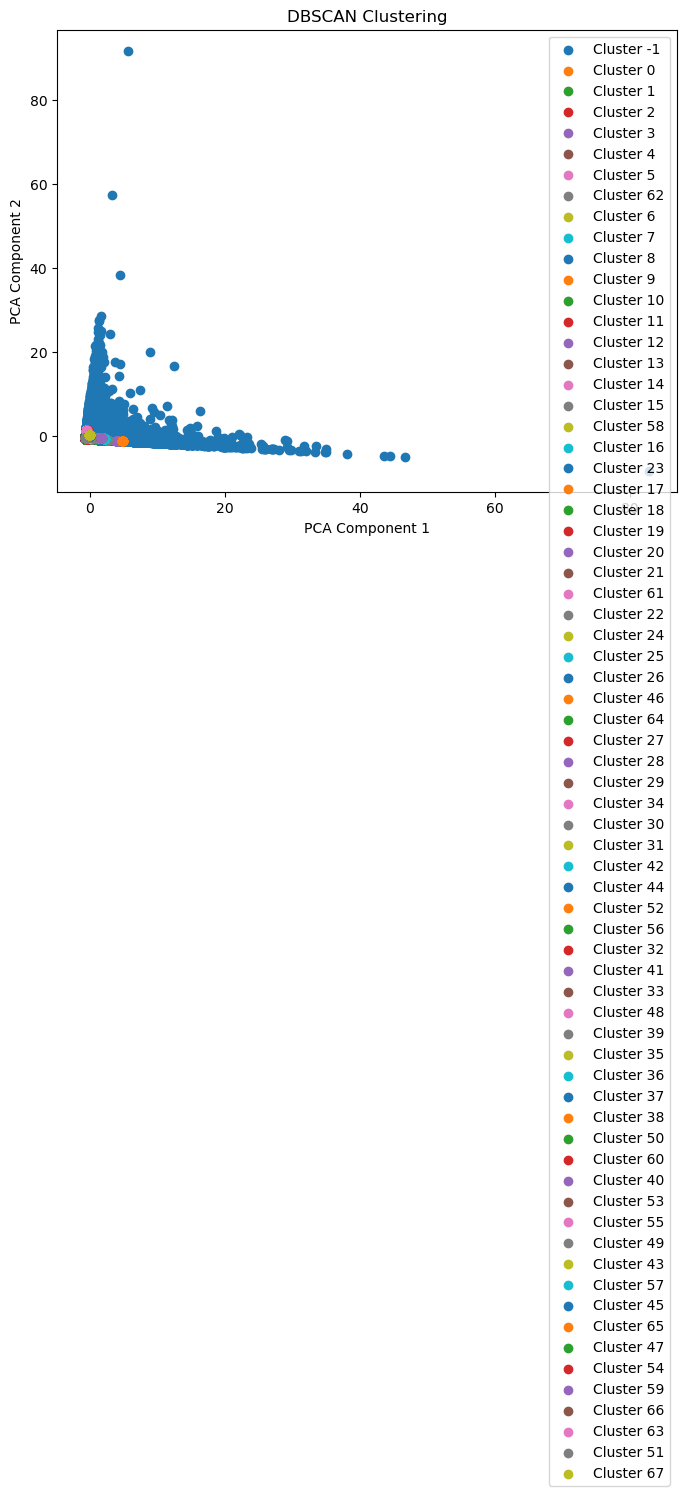

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce dimensions using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plotting the clusters
plt.figure(figsize=(8, 6))

# Create a scatter plot for each cluster label
for label in filtered_data['cluster_label'].unique():
    cluster_data = X_pca[filtered_data['cluster_label'] == label]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {label}')

plt.title('DBSCAN Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

## 4. Command Line Question


Here is another command line question to enjoy. We previously stated that using the command line tools is a skill that Data Scientists must master.

In this question, you should use any command line tool that you know to answer the following questions using the same dataset that you have been using so far:
  + What is the most-watched Netflix title?
  + Report the average time between subsequent clicks on Netflix.com
  + Provide the ID of the user that has spent the most time on Netflix
    
__Important note:__ You may work on this question in any environment (AWS, your PC command line, Jupyter notebook, etc.), but the final script must be placed in CommandLine.sh, which must be executable. Please run the script and include a __screenshot__ of the <ins>output</ins> in the notebook for evaluation.  

### Here is the code for Q1, Q2, and Q3.

In [ ]:
#!/bin/bash

#-----------------  Q-1  --------------------

echo "Q-1 Answer: "

file='vodclickstream_uk_movies_03.csv'

# we use 'awk' as a text-processing tool.
# -F is the field-separator. we separate the fields by ','
# we then, print the 4th column of each row
# The output of the awk which are titles, should pipe to 'sort', using '|' operator.
# uniq -c counts the occurrences of each unique title
# The output of 'uniq -c' (which includes the count and the title) should be piped to 'sort -nr' which sorts numerically (by the count) and reverse the order
# '| head -1:' returns the first line of the result.

# Extracting the fourth column ('title') and counting occurrences
most_occurred_title=$(awk -F ',' '{print $4}' "$file" | sort | uniq -c | sort -nr | head -1)

echo "Most occurred title and its count:"
echo "$most_occurred_title"


#-----------------  Q-2  --------------------

echo "Q-2 Answer: "

# split($2, date, /[:-]/): Splits the second column ($2) of the current line into an array named date, using /[:-]/ as the separator.
# Then we convert the date and time components to seconds and sum up all these values to get the total time in seconds.
# diff += time - prev: Calculates the difference between consecutive rows in seconds and accumulates it in the diff variable.
# count++: counts the number of rows.
# prev = time: Updates the previous time variable for the next iteration.
# Once all codes executed before END, compiler runs the code after END.

awk -F ',' 'NR > 1 {
    split($2, date, /[:-]/); 
    time = date[1]*365*24*60*60 + date[2]*30*24*60*60 + date[3]*24*60*60 + date[4]*60*60 + date[5]*60 + date[6]; 
    diff += time - prev; 
    count++; 
    prev = time
} 
END {
    avg_diff = diff/count; 
    hours = int(avg_diff / 3600); 
    minutes = int((avg_diff % 3600) / 60); 
    seconds = int(avg_diff % 60); 
    print "Average difference:", diff/count;
    print "Average difference:", hours " hours, " minutes " minutes, " seconds " seconds";
}' vodclickstream_uk_movies_03.csv


#-----------------  Q-3  --------------------

echo "Q-3 Answer: "

# Read the CSV file
# awk -F',' means that he input fields in the file are separated by commas 
# {sums[$NF]+=$3} creates an array called sums. it sum up the durations ($3) for each unique user_id. ($NF represents the last column). 
# After END, compiler iterates through the sums array and prints each user_id and its total duration.

# Read the CSV file and use awk to sum up durations for each user_id
result=$(awk -F ',' '{sums[$NF]+=$3} END {for (id in sums) print id, sums[id]}' vodclickstream_uk_movies_03.csv)

# Find the user_id with the maximum total duration
# sort -nrk2 sorts the output numerically (-n) based on the second column (-k2) in reverse order (-r)
# head -n1 selects only the first line
max_duration=$(echo "$result" | sort -nrk2 | head -n1)

# Extract user_id and total duration
max_user_id=$(echo "$max_duration" | awk '{print $1}')
total_seconds=$(echo "$max_duration" | awk '{print $2}')

# Convert total duration to hours, minutes, and seconds
hours=$((total_seconds / 3600))
minutes=$(( (total_seconds % 3600) / 60 ))
seconds=$((total_seconds % 60))

echo "User_id with the most total duration: $max_user_id"
echo "Total duration: $hours hours, $minutes minutes, $seconds seconds"




### Here is the result of all 3 questions:

![](./CLQ/CLQ-screenshot.png)

## 5. Algorithmic Question 



Federico studies in a demanding university where he has to take a certain number $N$ of exams to graduate,  but he is free to choose in which order he will take these exams. Federico is panicking since this university is not only one of the toughest in the world but also one of the weirdest. His final grade won't depend at all on the mark he gets in these courses: there's a precise evaluation system. 

He was given an initial personal score of $S$ when he enrolled, which changes every time he takes an exam: now comes the crazy part.
He soon discovered that every of the $N$ exams he has to take is assigned a mark $p$. Once he has chosen an exam, his score becomes equal to the mark $p$, and at the same time, the scoring system changes:
+ If he takes an "easy" exam (the score of the exam being less than his score), every other exam's mark is increased by the quantity $S - p$.
+ If he takes a "hard" exam (the score of the exam is greater than his score), every other exam's mark is decreased by the quantity $p - S$.

So, for example, consider $S=8$ as the initial personal score. Federico must decide which exam he wants to take, being $[5,7,1]$ the marks list. If he takes the first one, being $5 < 8$ and $8 - 5 = 3$, the remaining list now becomes $[10,4]$, and his score is updated as $S = 5$.

In this chaotic university where the only real exam seems to be choosing the best way to take exams, you are the poor student advisor who is facing a long queue of confused people who need some help. Federico is next in line,  and he comes up in turn with an inescapable question: he wants to know which is the highest score possible he could get. 

a) Fortunately, you have a computer app designed by a brilliant student. Federico wants you to show him the code which this app is based on
because he wants to do paid counseling for other desperate students: in a *recursive* fashion, the helped helps the helpable.

b) Federico is getting angry because he claims that your code is slow! Show him formally with a big-O notation that he is as crazy as this university! 

c) If, unfortunately, Federico is right in the grip of madness, he will threaten you to optimize the code through a different approach. 
You should end this theater of the absurd by any means! (And again, formally prove that you improved time complexity)

d) Ask chatGPT for a third (optimized) implementation and analyze again its time complexity. Be careful (and crafty) in defining the prompt, and challenge the machine in this coding question!

Here are some input/output examples (the first value is the initial personal score, and the second line contains the list of marks): 

__Input 1__
```
8
5 7 1 
```

__Output 1__
```
11
```

__Input 2__
```
25
18 24 21 32 27
```

__Output 2__
```
44
```

__Input 3__
```
30
13 27 41 59 28 33 39 19 52 48 55 79
```

__Output 3__
```
205
```

### 5.1. Recursive approach 

Federico requires an algorithm that allows students to achieve their optimal personal score through a *recursive* approach. Our initial strategy involves utilizing the DFS (Depth-First Search) algorithm. The methodology is as follows:

1. Implement a `for` loop where we process each element in the array. This involves:
   - Setting the current element as the new score.
   - Calculating the total score.
   - Creating a modified array of exams, excluding the current element, and updating this array while retaining the original array.

2. Determine the maximum score by comparing the current `max_score` with the result of a recursive call, which takes the new score and the updated exams array as parameters.

3. Continue this process until all possible iterations through the array are completed.


In [ ]:
def exams_v0(score, exams):
    if len(exams) == 1:
        return exams[0]

    max_score = 0
    for i in range(len(exams)):
        new_score = exams[i]
        new_quantity = score - new_score
        new_exams = [x + new_quantity for idx, x in enumerate(exams) if idx != i]
        max_score = max(max_score, exams_v0(new_score, new_exams))

    return max_score


print(exams_v0(8, [5, 7, 1]))  # Expected output: 11
print(exams_v0(25, [18, 24, 21, 32, 27]))  # Expected output: 44
print(exams_v0(30, [13, 27, 41, 59, 28, 33, 39, 19, 52, 48, 55, 79]))  # Expected output: 205

11
44
205


However, this approach becomes significantly slow when dealing with a large number of examples (as seen in example 3). A different strategy is required. We propose implementing the DFS algorithm with the addition of memoization to track previous states. This method essentially constitutes Dynamic Programming. By employing this approach, we expect:

- **Improved Time Complexity:** The overall processing time should be significantly reduced.
- **Space Trade-Off:** Additional memory will be required to store all the states, which is a trade-off for the enhanced time efficiency.


In [ ]:
def exams_v1(score, exams, memo={}):
    if len(exams) == 1:
        return exams[0]
    if (score, tuple(exams)) in memo:
        return memo[(score, tuple(exams))]

    max_score = 0
    for i in range(len(exams)):
        new_score = exams[i]
        new_quantity = score - new_score
        new_exams = [x + new_quantity for idx, x in enumerate(exams) if idx != i]
        max_score = max(max_score, exams_v1(new_score, new_exams, memo))

    memo[(score, tuple(exams))] = max_score
    return max_score


print(exams_v1(8, [5, 7, 1]))  # Expected output: 11
print(exams_v1(25, [18, 24, 21, 32, 27]))  # Expected output: 44
print(exams_v1(30, [13, 27, 41, 59, 28, 33, 39, 19, 52, 48, 55, 79]))  # Expected output: 205

11
44
205


When comparing the running times of the two approaches, the benefits of memoization become evident:

- **Without Memoization:** The running time is approximately 9 minutes and 21 seconds.
- **With Memoization:** The running time is significantly reduced to just 0.6 seconds.

Given these results, this approach is markedly more efficient for our current situation. Particularly in systems handling a large number of students, if the space constraint is not an issue, state memoization can greatly expedite the computation of maximum scores. This is especially true in scenarios where similar problems have already been encountered, allowing the system to leverage previous computations to speed up the process.


### 5.2. Big-O notation for the recursive algorithm 

The `exams_v1` function is a recursive algorithm with memoization, so analyzing its time complexity can be difficult.

The time complexity, without memoization, would be exponential in the size of the `exams` list, approximately `O(n!)`, where `n` is the length of the `exams` list. This is due to exploring all possible combinations of exams in recursive style. 

With memoization, the time complexity is significantly reduced in average case. The complexity largely depends on the number of unique states, which are determined by the combination of the current score and the remaining exams. However, still in the worst case scenario the time complexity remains `O(n!)`, with also having much worse space complexity. 


### 5.3. New approach!

A different approach is necessary. After exploring various strategies, the most effective one seems to involve sorting the `exams` array and then dividing it into two arrays: `easier_exams` and `harder_exams`. For an uneven number of exams, the `harder_exams` array will contain one additional element. The process unfolds as follows:

1. **Initial Selection:**
   - Select the easiest exam in `harder_exams` if the length of `harder_exams` is larger than the total in `easier_exams`.
   - Otherwise, opt for the easiest exam from `easier_exams`.

2. **Score Assignment:**
   - This selected exam becomes the new score.
   - Remove the chosen exam from its array.

3. **Calculation and Update:**
   - Calculate the necessary quantity.
   - Update both the `easier_exams` and `harder_exams` arrays accordingly.

4. **Iteration:**
   - Update the current score to the value of the `new_score`.
   - Continue this process until all exams are addressed.

The idea behind this strategy is to tackle the hardest exam at the end, thereby benefiting from the increased value accumulated from the last easy exam.

In [ ]:
def exams_v2(score, exams):
    if len(exams) == 1:
        return exams[0]

    sorted_exams = sorted(exams)
    easier_exams = sorted_exams[: (len(exams) // 2)]
    harder_exams = sorted_exams[len(exams) // 2 : len(exams)]
    while len(harder_exams) > 0:
        if len(harder_exams) == len(easier_exams):
            new_score = easier_exams[0]
            del easier_exams[0]
        else:
            new_score = harder_exams[0]
            del harder_exams[0]

        new_quantity = score - new_score
        harder_exams = [x + new_quantity for x in harder_exams]
        easier_exams = [x + new_quantity for x in easier_exams]
        score = new_score

    return score


print(exams_v2(8, [5, 7, 1]))  # Expected output: 11
print(exams_v2(25, [18, 24, 21, 32, 27]))  # Expected output: 44
print(exams_v2(30, [13, 27, 41, 59, 28, 33, 39, 19, 52, 48, 55, 79])) # Expected output: 205

11
44
205


After checking the results, they match what we got from the earlier algorithms, suggesting our new implementation is correct.

#### Time complexity

The time complexity of the `exams_v2` function can be broken down as follows:

1. **Sorting the Exams Array:**
   - The `sorted()` function is used, which typically has a time complexity of `O(n log n)` where `n` is the number of elements in the `exams` array.

2. **Splitting the Array:**
   - Dividing the array into `easier_exams` and `harder_exams` is a constant time operation, `O(1)`, involving basic arithmetic and slicing.

3. **While Loop:**
   - The loop iterates over `harder_exams`, potentially up to `n/2` times in the worst case.
   - Within each iteration:
     - Removing the first element (`del`) is `O(n)` as it requires shifting all elements.
     - Updating `harder_exams` and `easier_exams` is `O(n)` for each list, totaling `O(n)` per iteration.

Combining these complexities:

- The initial sorting is `O(n log n)`.
- The while loop, with its operations, contributes `O(n^2/2)`.

`O(n^2/2)` takes priority over `O(n log n)`, therfore, the overall time complexity is approximately `O(n^2)`.

When compared to our previous implementations, this approach is significantly faster and does not require the additional space that was needed for memoization. Thus, Federico is likely to be more satisfied with this solution.

### 5.4. Third approach (ChatGPT)

For our final approach, we plan to consult ChatGPT for a third, optimized implementation. Our objective is to:

1. Provide ChatGPT with the latest version of our code.
2. Clearly explain the task requirements.
3. Analyze the time complexity of the suggested optimized solution.

This will help us determine if there is an improvement in time complexity compared to our previous methods.


Prompt that was used is following: 

"I need a optimized solution for this task: `(explanation of the task)`. The code that was already done is next one:
```python
def exams_v2(score, exams):
    if len(exams) == 1:
        return exams[0]

    sorted_exams = sorted(exams)
    easier_exams = sorted_exams[: (len(exams) // 2)]
    harder_exams = sorted_exams[len(exams) // 2 : len(exams)]
    while len(harder_exams) > 0:
        if len(harder_exams) == len(easier_exams):
            new_score = easier_exams[0]
            del easier_exams[0]
        else:
            new_score = harder_exams[0]
            del harder_exams[0]

        new_quantity = score - new_score
        harder_exams = [x + new_quantity for x in harder_exams]
        easier_exams = [x + new_quantity for x in easier_exams]
        score = new_score

    return score


print(exams_v2(8, [5, 7, 1]))  # Expected output: 11
print(exams_v2(25, [18, 24, 21, 32, 27]))  # Expected output: 44
print(exams_v2(30, [13, 27, 41, 59, 28, 33, 39, 19, 52, 48, 55, 79])) # Expected output: 205
```
One of the problems is O(n^2) complexity inside the while loop, so different approach is needed."



After a few prompts and explaining the problem in more detail, the code that was produced was next one:

In [ ]:
from collections import deque

def exams_v3(score, exams):
    if len(exams) == 1:
        return exams[0]

    sorted_exams = sorted(exams)
    mid_index = len(exams) // 2
    easier_exams = deque(sorted_exams[:mid_index])
    harder_exams = deque(sorted_exams[mid_index:])

    cumulative_adjustment = 0

    while harder_exams or easier_exams:
        if len(harder_exams) == len(easier_exams):
            current_exam = easier_exams.popleft()
        else:
            current_exam = harder_exams.popleft()

        current_exam += cumulative_adjustment
        new_score = score - current_exam
        cumulative_adjustment += new_score
        score = current_exam

    return score

print(exams_v3(8, [5, 7, 1]))  # Expected output: 11
print(exams_v3(25, [18, 24, 21, 32, 27]))  # Expected output: 44
print(exams_v3(30, [13, 27, 41, 59, 28, 33, 39, 19, 52, 48, 55, 79])) # Expected output: 205


11
44
205


The primary difference between these two codes lies in the use of `deque` instead of a regular list. With `deque`, we can utilize `popleft()`, which is an `O(1)` operation, in contrast to the `O(n)` operation when using regular lists. This approach also avoids recalculating all remaining exam scores in each iteration. Instead, it updates a `cumulative_adjustment` variable, which is now also an `O(1)` operation. As a result, the overall time complexity is reduced to `O(nlog(n))`, making it a much more optimized solution compared to the `exams_v2` approach.

Additionally, with the use of ChatGPT version 4, prompt was asked to compare their execution times. Here are the results:
- `exams_v2`: approximately 0.060 seconds
- `exams_v3`: approximately 0.00084 seconds
